## Data Collection and Cleaning

First we get a collection of the last years worth of player injuries 

In [198]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def nba_injuries(start_date="2020-01-01", end_date="2023-01-01", player="", team=""):
    try:
        player = player.replace(" ", "+")
        base_url = "https://www.prosportstransactions.com/basketball/Search/SearchResults.php"
        css_selector = ".datatable"
        start = 0
        all_pages_data = []

        while True:
            params = {
                "Player": player,
                "Team": team,
                "BeginDate": start_date,
                "EndDate": end_date,
                "ILChkBx": "yes",
                "InjuriesChkBx": "yes",
                "PersonalChkBx": "yes",
                "Submit": "Search",
                "start": start
            }

            response = requests.get(base_url, params=params)
            soup = BeautifulSoup(response.content, 'html.parser')
            table = soup.select_one(css_selector)

            if table:
                df = pd.read_html(str(table))[0]
                df.columns = df.iloc[0]  # Set the first row as column names
                df = df[1:]  # Remove the first row
                all_pages_data.append(df)

                # Check for the 'Next' link - if it doesn't exist, break the loop
                if not soup.find('a', text='Next'):
                    break
                
                start += 25  # Update start for next page
            else:
                break

        # Combine all pages data into one DataFrame
        if all_pages_data:
            final_df = pd.concat(all_pages_data, ignore_index=True)
            final_df['Date'] = pd.to_datetime(final_df['Date'])
            final_df['Acquired'] = final_df['Acquired'].str.replace("… ", "")
            final_df['Relinquished'] = final_df['Relinquished'].str.replace("… ", "")
            return final_df
        else:
            print("No data found for the given parameters.")
            return pd.DataFrame()  # Return empty DataFrame if no data found

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return empty DataFrame in case of error

# Example usage
df = nba_injuries()


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/2765107248.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/2765107248.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/2765107248.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/2765107248.py:32: FutureWarning: Passing literal html to 'read_html' is deprec

In [199]:
df.to_csv('out.csv', index=False) 

In [200]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
current_date = pd.to_datetime('2023-01-01')

# Melt the DataFrame to unify 'Relinquished' and 'Acquired' under a single 'Player' column
latest_dates = df.melt(id_vars='Date', value_vars=['Relinquished', 'Acquired'], var_name='Status', value_name='Player')
latest_dates = latest_dates.dropna(subset=['Player']).sort_values(by='Date', ascending=False)
latest_dates = latest_dates.drop_duplicates(subset=['Player'], keep='first')

# Create a 'Got Injured' column: 1 if 'Relinquished', 0 if 'Acquired'
latest_dates['Got Injured'] = (latest_dates['Status'] == 'Relinquished').astype(int)

# Aggregate original data for players listed in 'Relinquished'
grouped_df = df.dropna(subset=['Relinquished']).groupby('Relinquished').agg({
    'Date': lambda x: (current_date - max(x)).days,
    'Notes': lambda x: list(x.dropna())
}).reset_index()

# Merge the aggregated data with the latest_dates to include the 'Got Injured' status
grouped_df = grouped_df.merge(latest_dates[['Player', 'Got Injured']], left_on='Relinquished', right_on='Player', how='left')

# Rename columns for clarity and avoid deleting necessary columns
grouped_df = grouped_df.rename(columns={'Relinquished': 'Player', 'Date': 'Days Since Last Injury', 'Notes': 'List of Past Injuries','Player':'DROP'})
grouped_df.drop(columns = ["DROP"],inplace = True)
grouped_df

,Player,Days Since Last Injury,List of Past Injuries,Got Injured
0,• (James) Mike Scott,615,"[placed on IL with sore right knee, placed on ...",0
1,• (Sean) Chris Smith,284,"[surgery on left knee (out indefinitely), spra...",0
2,• A.J. Green,64,[placed on IL with fractured nose],0
3,• Aaron Gordon,5,"[placed on IL with right calf injury, placed o...",0
4,• Aaron Henry,367,"[placed on IL, placed on IL, placed on IL, pla...",0
...,...,...,...,...
703,• Zhaire Smith,1057,[placed on IL with left knee injury (out for s...,1
704,• Ziaire Williams,74,"[sore right wrist (DTD), placed on IL with sor...",1
705,• Zion Williamson,10,"[sprained left ankle (DTD), placed on IL, plac...",0
706,• Zylan Cheatham,368,[placed on IL with NBA health and safety proto...,0


In [201]:
injury_types = ["core", "upper body", "ligament", "foot", "back"]

def filter_injury_types(injuries_list):
    """Filters a list of injuries to include only predefined injury types."""
    filtered_types = []
    for injury in injuries_list:
        for injury_type in injury_types:
            if injury_type in injury.lower():
                filtered_types.append(injury_type)
    return filtered_types

#grouped_df['Injury Types'] = grouped_df['List of Past Injuries'].apply(has_injury_type)

# Apply the function to filter and extract relevant injury types
grouped_df['Filtered Injuries'] = grouped_df['List of Past Injuries'].apply(filter_injury_types)

# Explode the list of filtered injuries into separate rows
exploded_df = grouped_df.explode('Filtered Injuries')

# Create dummy variables for each injury type
injury_dummies = pd.get_dummies(exploded_df['Filtered Injuries'])
grouped_df = grouped_df.join(injury_dummies.groupby(level=0).sum())

# Ensure all injury types are represented in the DataFrame
for injury_type in injury_types:
    if injury_type not in grouped_df.columns:
        grouped_df[injury_type] = 0

# Optionally, select only the injury type columns
grouped_df = grouped_df[['Player', 'Days Since Last Injury',"Got Injured"] + injury_types]


# Display the updated DataFrame
print(grouped_df)

                        Player  Days Since Last Injury  Got Injured  core  \
0         • (James) Mike Scott                     615            0     0   
1         • (Sean) Chris Smith                     284            0     0   
2                 • A.J. Green                      64            0     0   
3               • Aaron Gordon                       5            0     0   
4                • Aaron Henry                     367            0     0   
..                         ...                     ...          ...   ...   
703             • Zhaire Smith                    1057            1     0   
704          • Ziaire Williams                      74            1     0   
705          • Zion Williamson                      10            0     0   
706           • Zylan Cheatham                     368            0     0   
707  • left wrist injury (DTD)                     735            1     0   

     upper body  ligament  foot  back  
0             0         0     0    

In [202]:
grouped_df['Player'] = grouped_df['Player'].str.replace('•', '')
#grouped_df["Got Injured"] = grouped_df['Days Since Last Injury'] <= 3
#grouped_df["Got Injured"] = grouped_df["Got Injured"].astype(int)
grouped_df.head()

,Player,Days Since Last Injury,Got Injured,core,upper body,ligament,foot,back
0,(James) Mike Scott,615,0,0,0,0,0,0
1,(Sean) Chris Smith,284,0,0,0,0,0,0
2,A.J. Green,64,0,0,0,0,0,0
3,Aaron Gordon,5,0,0,0,0,1,0
4,Aaron Henry,367,0,0,0,0,0,0


In [210]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def fetch_last_5_games_data(player_url):
    response = requests.get(player_url)
    if response.status_code != 200:
        print(f"Failed to retrieve the web page. Status code: {response.status_code}")
        return None
    if response.status_code == 429:
            retry_after = int(response.headers.get("Retry-After", 10))  # Default to 30 seconds if header is missing
            print(f"Rate limit reached, retrying after {retry_after} seconds")
            print("Timer:", retry_after)
            time.sleep(retry_after)
            

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the div containing the last 5 games data
    last5_div = soup.find('div', id='all_last5')
    if not last5_div:
        print("Last 5 games div not found.")
        return None

    # The table might be directly inside the div
    table = last5_div.find('table')
    if not table:
        print("Last 5 games table not found.")
        return None

    # Parse the table with pandas
    df = pd.read_html(str(table))[0]
    
    # Clean and process the DataFrame to have the desired columns
    
    df['GameLocation'] = df.apply(lambda row: row['Opp'].replace('@', '').strip() 
                                  if '@' in row['Opp'] else row['Team'], axis=1)

    # Clean the 'MP' column, which represents minutes played
    df['MP'] = df['MP']

    # Select and rename the relevant columns
    relevant_data = df[['Date', 'MP', 'GameLocation']].rename(columns={
        'MP': 'TimePlayed'
    })

    return relevant_data

# Example usage
player_url = "https://www.basketball-reference.com/players/g/greenje02.html"
last_5_games_df = fetch_last_5_games_data(player_url)
print(last_5_games_df)



Failed to retrieve the web page. Status code: 429
Rate limit reached, retrying after 2039 seconds


KeyboardInterrupt: 

In [204]:
import requests
from bs4 import BeautifulSoup

def search_for_player_page(player_name):
    # Encode the player's name for use in a URL
    query = player_name.replace(' ', '+')

    # The base URL for the basketball-reference search
    search_url = f'https://www.basketball-reference.com/search/search.fcgi?search={query}'
    
    # Perform the search request
    response = requests.get(search_url)
    
    # If the response URL is a player page, return it directly
    if 'players' in response.url:
        return response.url
    
    if response.status_code != 200:
        print(f"Failed to retrieve the search page. Status code: {response.status_code}")
        return None

    # Parse the search results page to find links
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Look for the div that contains the search results
    search_results = soup.find('div', id='players')
    
    if search_results:
        # Attempt to find an anchor element within the search results
        player_link = search_results.find('a')
        
        if player_link and 'href' in player_link.attrs:
            # Construct the full URL to the player's page
            player_page_url = 'https://www.basketball-reference.com' + player_link['href']
            return player_page_url
        else:
            print("No player link found in the search results.")
            return None
    else:
        print("No search results found for the player.")
        return None

# Example usage
player_name = "LeBron James"
player_page_url = search_for_player_page(player_name)
print(f"Player page URL: {player_page_url}")

Player page URL: https://www.basketball-reference.com/players/j/jamesle01.html


In [205]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re

def fetch_player_info(player_url):
    response = requests.get(player_url)
    if response.status_code != 200:
        return f"Failed to retrieve the web page. Status code: {response.status_code}"

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extracting the player's name from the <h1> tag
    player_name = soup.select_one('.players h1').text.strip() if soup.select_one('.players h1') else "Unknown"

    # Extracting the position, height, weight, and birth date from the player's meta information
    meta_info = soup.find('div', id='meta')

    # Position
    # Position
    position_tag = meta_info.find('strong', text=lambda x: x and 'Position:' in x)
    position = position_tag.next_sibling.strip() if position_tag and position_tag.next_sibling else "Unknown"


    # Height and Weight
    
    height_weight_text = meta_info.find('span', text=lambda x: x and 'lb' in x)
    height = height_weight_text.next_sibling.strip() if height_weight_text else "Unknown"
    weight = height_weight_text.text.strip() if height_weight_text else "Unknown"
    
    # Birth date for age calculation
    birth_date_tag = meta_info.find('span', id='necro-birth')
    birth_date_str = birth_date_tag['data-birth'] if birth_date_tag else "Unknown"

    if birth_date_str != "Unknown":
        birth_date = datetime.strptime(birth_date_str, '%Y-%m-%d').date()
        today = datetime.now().date()
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    else:
        age = "Unknown"

    # Weight
    weight_match = re.search(r"\d+", weight)
    weight = int(weight_match.group()) if weight_match else "Unknown"

    # Experience
    experience = meta_info.find('strong', text='Experience:').next_sibling.strip() if meta_info.find('strong', text='Experience:') else "Unknown"
    experience_match = re.search(r"\d+", experience)
    experience = int(experience_match.group()) if experience_match else "Unknown"

    player_data = {
        'Name': player_name,
        'Position': position.split(",")[0],
        'Height': int(re.search(r"(\d+)cm", height).group(1)),
        'Weight': weight,
        'Age': age,
        'Experience': experience
    }

    return player_data

# Example usage
player_url = "https://www.basketball-reference.com/players/j/jamesle01.html"
player_info = fetch_player_info(player_url)
print(player_info)
print(type(player_info))


{'Name': 'LeBron James', 'Position': 'Small Forward', 'Height': 206, 'Weight': 250, 'Age': 39, 'Experience': 20}
<class 'dict'>


In [212]:
import time
import pandas as pd

basic_info = pd.DataFrame(columns=['Name', 'Position', 'Height', 'Weight', 'Age', 'Experience'])
last_five_games = pd.DataFrame(columns=['Name', 'Last_5_Games'])

# Default values for last 5 games, assuming you expect 5 entries
default_game_data = [None] * 5  # Replace None with a more appropriate default if needed

for name in grouped_df["Player"]:
    time.sleep(10)  
    print(f"Processing {name}")
    my_url = search_for_player_page(name)
    if not my_url:
        continue
    my_basic_info = fetch_player_info(my_url)
    my_five_games = fetch_last_5_games_data(my_url)

    # If data is fetched, use it, otherwise stick with defaults
    actual_game_data = list(my_five_games["TimePlayed"]) if my_five_games is not None else default_game_data

    # Ensure the list is always of length 5
    actual_game_data = actual_game_data[:5] + [None] * (5 - len(actual_game_data))

    # Dictionary for DataFrame
    # Proposed addendum: five_games_df = {"Name": [name], "Last_5_Games": [actual_game_data], "Location of Games": [my_five_games["Location"]]}
    five_games_df = {"Name": [name], "Last_5_Games": [actual_game_data]}
    my_basic_info = {key: [value] for key, value in my_basic_info.items()}
    
    # Create and append to DataFrame as before
    basic_info = pd.concat([basic_info, pd.DataFrame(my_basic_info)], ignore_index=True)
    last_five_games = pd.concat([last_five_games, pd.DataFrame(five_games_df)], ignore_index=True)

# Save DataFrames to CSV
basic_info.to_csv("basic_info.csv", encoding='utf-8', index=False)
last_five_games.to_csv("last_five_games.csv", encoding='utf-8', index=False)


Processing  (James) Mike Scott
No search results found for the player.
Processing  (Sean) Chris Smith
No search results found for the player.
Processing  A.J. Green


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Aaron Gordon


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Aaron Henry
Last 5 games div not found.
Processing  Aaron Holiday


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Aaron Nesmith


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Aaron Wiggins


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Abdel Nader
Last 5 games div not found.
Processing  Adam Mokoka
Last 5 games div not found.
Processing  Admiral Schofield


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Al Horford


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Al-Farouq Aminu
Last 5 games div not found.
Processing  Alec Burks


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Aleksej Pokusevski


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Alen Smailagic
Last 5 games div not found.
Processing  Alex Caruso


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Alex Len


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Alfonzo McKinnie
Last 5 games div not found.
Processing  Alize Johnson
Last 5 games div not found.
Processing  Allen Crabbe
Last 5 games div not found.
Processing  Allonzo Trier
Last 5 games div not found.
Processing  Alondes Williams


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Alperen Sengun


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Amir Coffey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Andre Drummond


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Andre Iguodala
Last 5 games div not found.
Processing  Andre Roberson
Last 5 games div not found.
Processing  Andrew Nembhard


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Andrew Wiggins


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Anfernee Simons


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ante Zizic
Last 5 games div not found.
Processing  Anthony Davis


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Anthony Edwards


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Anthony Gill


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Anthony Lamb
Last 5 games div not found.
Processing  Anthony Tolliver
Last 5 games div not found.
Processing  Anzejs Pasecniks
Last 5 games div not found.
Processing  Armoni Brooks


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Aron Baynes
Last 5 games div not found.
Processing  Austin Reaves


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Austin Rivers
Last 5 games div not found.
Processing  Avery Bradley
Last 5 games div not found.
Processing  Axel Toupane
Last 5 games div not found.
Processing  Ayo Dosunmu


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  B.J. Johnson
Last 5 games div not found.
Processing  Ben McLemore
Last 5 games div not found.
Processing  Ben Simmons


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Blake Griffin
Last 5 games div not found.
Processing  Blake Wesley


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Boban Marjanovic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bobby Portis


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bogdan Bogdanovic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bojan Bogdanovic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bol Bol
Last 5 games div not found.
Processing  Brad Wanamaker
Last 5 games div not found.
Processing  Bradley Beal


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Brandon Boston Jr. / B.J. Boston Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Brandon Clarke


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Brandon Goodwin
Last 5 games div not found.
Processing  Brandon Ingram


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Brandon Knight
Last 5 games div not found.
Processing  Brandon Williams (b. 1975-02-27)
No search results found for the player.
Processing  Brian Bowen II
Last 5 games div not found.
Processing  Brodric Thomas
Last 5 games div not found.
Processing  Brook Lopez


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bruce Brown


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bruno Caboclo
Last 5 games div not found.
Processing  Bruno Fernando


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Bryn Forbes
Last 5 games div not found.
Processing  Buddy Hield


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  C.J. Elleby
No search results found for the player.
Processing  C.J. McCollum
Last 5 games div not found.
Processing  C.J. Miles
Last 5 games div not found.
Processing  Cade Cunningham


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Caleb Martin


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cam Reddish


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cameron Johnson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cameron McGriff
Last 5 games div not found.
Processing  Cameron Oliver
Last 5 games div not found.
Processing  Cameron Payne


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cameron Thomas / Cam Thomas
No search results found for the player.
Processing  Caris LeVert


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Carmelo Anthony
Last 5 games div not found.
Processing  Carsen Edwards
Last 5 games div not found.
Processing  Cassius Winston
Last 5 games div not found.
Processing  Cedi Osman


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chandler Hutchison
Last 5 games div not found.
Processing  Chandler Parsons
Last 5 games div not found.
Processing  Charles Bassey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chasson Randle
Last 5 games div not found.
Processing  Chaundee Brown Jr.
Last 5 games div not found.
Processing  Chet Holmgren


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chima Moneke
Last 5 games div not found.
Processing  Chimezie Metu


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chris Boucher


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chris Chiozza
Last 5 games div not found.
Processing  Chris Clemons
Last 5 games div not found.
Processing  Chris Duarte


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chris Paul


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chris Silva
Last 5 games div not found.
Processing  Christian Wood


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Chuma Okeke


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Clint Capela


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Coby White


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cody Martin


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cody Zeller


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cole Anthony


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cole Swider


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Collin Gillespie


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Collin Sexton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Corey Kispert


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Cory Joseph


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Courtney Lee
Last 5 games div not found.
Processing  Cristiano Felicio
Last 5 games div not found.
Processing  D'Angelo Russell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  D.J. Augustine
No search results found for the player.
Processing  D.J. Wilson
Last 5 games div not found.
Processing  DaQuan Jeffries


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Daishen Nix


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dalano Banton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Damian Jones


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Damian Lillard


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Damion Lee
Last 5 games div not found.
Processing  Damyean Dotson
Last 5 games div not found.
Processing  Daniel Gafford


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Daniel Oturu
Last 5 games div not found.
Processing  Daniel Theis


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Danilo Gallinari


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Danny Green
Last 5 games div not found.
Processing  Dante Exum


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Danuel House Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dario Saric


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Darius Bazley


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Darius Garland


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Darius Miller
Last 5 games div not found.
Processing  Daulton Hommes
Last 5 games div not found.
Processing  David Duke Jr.
Last 5 games div not found.
Processing  David Johnson (Ricardo)
No search results found for the player.
Processing  David Nwaba
Last 5 games div not found.
Processing  Davion Mitchell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Davis Bertans


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Davon Reed
Last 5 games div not found.
Processing  Day'Ron Sharpe


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  De'Aaron Fox


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  De'Andre Hunter


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  De'Anthony Melton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  DeAndre Jordan


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  DeAndre' Bembry
Last 5 games div not found.
Processing  DeJon Jarreau


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  DeMar DeRozan


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  DeMarcus Cousins
Last 5 games div not found.
Processing  DeMarre Carroll
Last 5 games div not found.
Processing  Dean Wade


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Deandre Ayton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Deividas Sirvydis
Last 5 games div not found.
Processing  Dejounte Murray


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Delon Wright


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Deni Avdija


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dennis Schröder


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dennis Smith Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Denzel Valentine
Last 5 games div not found.
Processing  Deonte Burton
Last 5 games div not found.
Processing  Derrick Favors
Last 5 games div not found.
Processing  Derrick Jones Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Derrick Rose


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Derrick Walton Jr.
Last 5 games div not found.
Processing  Derrick White


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Desmond Bane


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Devin Booker


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Devin Cannady
Last 5 games div not found.
Processing  Devin Vassell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Devon Dotson
Last 5 games div not found.
Processing  Devontae Cacok
Last 5 games div not found.
Processing  Devonte' Graham


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dewan Hernandez
Last 5 games div not found.
Processing  Dewayne Dedmon
Last 5 games div not found.
Processing  Dillon Brooks


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dion Waiters
Last 5 games div not found.
Processing  Domantas Sabonis


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Donovan Mitchell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Donta Hall
Last 5 games div not found.
Processing  Donte DiVincenzo


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dorian Finney-Smith


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Doug McDermott


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Draymond Green


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Drew Eubanks


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Duane Washington Jr.
Last 5 games div not found.
Processing  Duncan Robinson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dwight Howard
Last 5 games div not found.
Processing  Dwight Powell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Dylan Windler


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  E'Twaun Moore
Last 5 games div not found.
Processing  E.J. Liddell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ed Davis (Adam)
No search results found for the player.
Processing  Edmond Sumner
Last 5 games div not found.
Processing  Edrice Adebayo / Bam Adebayo
No search results found for the player.
Processing  Elfrid Payton
Last 5 games div not found.
Processing  Elie Okobo
Last 5 games div not found.
Processing  Elijah Hughes
Last 5 games div not found.
Processing  Emmanuel Mudiay
Last 5 games div not found.
Processing  Enes Freedom / Enes Kanter
No search results found for the player.
Processing  Enes Kanter / Enes Freedom
No search results found for the player.
Processing  Eric Bledsoe
Last 5 games div not found.
Processing  Eric Gordon


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Eric Paschall
Last 5 games div not found.
Processing  Ersan Ilyasova
Last 5 games div not found.
Processing  Eugene Omoruyi


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Evan Fournier


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Evan Mobley


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Evan Turner
Last 5 games div not found.
Processing  Facundo Campazzo
Last 5 games div not found.
Processing  Frank Jackson
Last 5 games div not found.
Processing  Frank Kaminsky
Last 5 games div not found.
Processing  Frank Mason
Last 5 games div not found.
Processing  Frank Ntilikina


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Franz Wagner


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Fred VanVleet


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Furkan Korkmaz


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Gabe Vincent


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Gabriel Deck
Last 5 games div not found.
Processing  Garrett Temple


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Garrison Mathews


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Gary Clark Jr.
No search results found for the player.
Processing  Gary Harris


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Gary Payton II


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Gary Trent Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  George Hill
Last 5 games div not found.
Processing  Georges Niang


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Giannis Antetokounmpo


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Glenn Robinson III
Last 5 games div not found.
Processing  Goga Bitadze


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Goran Dragic
Last 5 games div not found.
Processing  Gordon Hayward


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Gorgui Dieng
Last 5 games div not found.
Processing  Grant Riller
Last 5 games div not found.
Processing  Grant Williams


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Grayson Allen


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Greg Brown III


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Greg Monroe
Last 5 games div not found.
Processing  Greg Whittington
Last 5 games div not found.
Processing  Guillermo Hernangomez / Willy Hernangomez
No search results found for the player.
Processing  Hamidou Diallo
Last 5 games div not found.
Processing  Harrison Barnes


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Harry Giles III
No search results found for the player.
Processing  Hassan Whiteside
Last 5 games div not found.
Processing  Hassani Gravett
Last 5 games div not found.
Processing  Heat
Last 5 games div not found.
Processing  Herbert Jones / Herb Jones (Keyshawn)
No search results found for the player.
Processing  Ignas Brazdeikis / Iggy Brazdeikis
No search results found for the player.
Processing  Iman Shumpert
Last 5 games div not found.
Processing  Immanuel Quickley


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaac Bonga
Last 5 games div not found.
Processing  Isaac Okoro


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Hartenstein


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Jackson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Joe


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Livers


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Roby
Last 5 games div not found.
Processing  Isaiah Stewart


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Thomas


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Isaiah Todd
Last 5 games div not found.
Processing  Ishmael Smith / Ish Smith
No search results found for the player.
Processing  Ishmail Wainright / Ish Wainright
No search results found for the player.
Processing  Ivica Zubac


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  J.D. Davison
No search results found for the player.
Processing  J.J. Redick
No search results found for the player.
Processing  J.T. Thor
No search results found for the player.
Processing  Ja Morant


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  JaKarr Sampson
Last 5 games div not found.
Processing  JaMychal Green
Last 5 games div not found.
Processing  JaQuori McLaughlin
Last 5 games div not found.
Processing  JaVale McGee


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jabari Parker
Last 5 games div not found.
Processing  Jacob Evans
Last 5 games div not found.
Processing  Jaden Ivey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jaden McDaniels


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jaden Springer


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jae Crowder


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jae'Sean Tate


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jahlil Okafor
Last 5 games div not found.
Processing  Jahmi'us Ramsey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jake LaRavia


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jake Layman
Last 5 games div not found.
Processing  Jakob Poeltl


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Brunson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Duren


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Green


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Harris
Last 5 games div not found.
Processing  Jalen Johnson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Lecque
Last 5 games div not found.
Processing  Jalen McDaniels


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Smith


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jalen Suggs


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jamal Crawford
Last 5 games div not found.
Processing  Jamal Murray


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  James Bouknight


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  James Ennis III
Last 5 games div not found.
Processing  James Harden


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  James Johnson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  James Wiseman


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jamorko Pickett
Last 5 games div not found.
Processing  Jared Butler


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jared Dudley
Last 5 games div not found.
Processing  Jared Harper
Last 5 games div not found.
Processing  Jaren Jackson Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jarred Vanderbilt


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jarrell Brantley
Last 5 games div not found.
Processing  Jarrett Allen


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jarrett Culver
Last 5 games div not found.
Processing  Jason Preston


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Javonte Green


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Javonte Smart
Last 5 games div not found.
Processing  Jaxson Hayes


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jay Scrubb
Last 5 games div not found.
Processing  Jaylen Adams
Last 5 games div not found.
Processing  Jaylen Brown


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jaylen Hoard
Last 5 games div not found.
Processing  Jaylen Nowell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jayson Tatum


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jeff Dowtin Jr.
No search results found for the player.
Processing  Jeff Green


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jeff Teague
Last 5 games div not found.
Processing  Jerami Grant


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jeremiah Robinson-Earl


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jeremy Lamb
Last 5 games div not found.
Processing  Jeremy Sochan


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jericho Sims


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jerome Robinson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jevon Carter


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jimmy Butler


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jock Landale


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Joe Harris


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Joe Ingles


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Joe Wieskamp
Last 5 games div not found.
Processing  Joel Embiid


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  John Butler Jr.
No search results found for the player.
Processing  John Collins (Martin)
No search results found for the player.
Processing  John Henson
Last 5 games div not found.
Processing  John Konchar


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  John Wall (Hildred)
No search results found for the player.
Processing  Johnny Davis (Christian)
No search results found for the player.
Processing  Johnny Juzang


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jonas Valanciunas


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jonathan Isaac


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jonathan Kuminga


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jontay Porter


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jordan Clarkson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jordan McLaughlin


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jordan McRae
Last 5 games div not found.
Processing  Jordan Nwora


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jordan Poole


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jose Alvarado


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Jose Juan Barea / Jose Barea / J.J. Barea
No search results found for the player.
Processing  Josh Giddey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Josh Green


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Josh Hall
Last 5 games div not found.
Processing  Josh Hart


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Josh Jackson
Last 5 games div not found.
Processing  Josh Okogie


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Josh Richardson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Joshua Primo
Last 5 games div not found.
Processing  Jrue Holiday


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Juan Toscano-Anderson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Juancho Hernangomez / Juan Hernangomez
No search results found for the player.
Processing  Julius Randle


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Justin Anderson
Last 5 games div not found.
Processing  Justin Champagnie


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Justin Holiday


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Justin Jackson (Aaron)
No search results found for the player.
Processing  Justin James
Last 5 games div not found.
Processing  Justin Patton
Last 5 games div not found.
Processing  Justise Winslow
Last 5 games div not found.
Processing  Jusuf Nurkic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Juwan Morgan
Last 5 games div not found.
Processing  K.Z. Okpala
No search results found for the player.
Processing  Kai Jones
Last 5 games div not found.
Processing  Karim Mane
Last 5 games div not found.
Processing  Karl-Anthony Towns


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kawhi Leonard


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Keegan Murray


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Keita Bates-Diop


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kelan Martin
Last 5 games div not found.
Processing  Keldon Johnson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Keljin Blevins
Last 5 games div not found.
Processing  Kelly Olynyk


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kelly Oubre Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kemba Walker
Last 5 games div not found.
Processing  Kendall Brown


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kendrick Nunn
Last 5 games div not found.
Processing  Kenny Wooten
Last 5 games div not found.
Processing  Kenrich Williams


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kent Bazemore
Last 5 games div not found.
Processing  Kentavious Caldwell-Pope


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kenyon Martin Jr. / K.J. Martin
Last 5 games div not found.
Processing  Keon Johnson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kessler Edwards


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kevin Durant


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kevin Huerter


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kevin Knox II
No search results found for the player.
Processing  Kevin Love


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kevin Pangos
Last 5 games div not found.
Processing  Kevin Porter Jr.
Last 5 games div not found.
Processing  Kevon Looney


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Khem Birch
Last 5 games div not found.
Processing  Khris Middleton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Khyri Thomas
Last 5 games div not found.
Processing  Killian Hayes


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Killian Tillie
Last 5 games div not found.
Processing  Kira Lewis Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Klay Thompson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kobi Simmons
Last 5 games div not found.
Processing  Kostas Antetokounmpo
Last 5 games div not found.
Processing  Kris Dunn


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kristaps Porzingis


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ky Bowman
Last 5 games div not found.
Processing  Kyle Alexander


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kyle Anderson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kyle Korver
Last 5 games div not found.
Processing  Kyle Kuzma


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kyle Lowry


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Kyle O'Quinn
Last 5 games div not found.
Processing  Kyrie Irving


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  LaMarcus Aldridge
Last 5 games div not found.
Processing  LaMelo Ball


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Lamar Stevens


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Lance Stephenson
Last 5 games div not found.
Processing  Landry Shamet


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Langston Galloway
Last 5 games div not found.
Processing  Larry Nance Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Lauri Markkanen


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  LeBron James


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Leandro Bolmaro
Last 5 games div not found.
Processing  Lindell Wigginton
Last 5 games div not found.
Processing  Lonnie Walker IV


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Lonzo Ball
Last 5 games div not found.
Processing  Louis King
Last 5 games div not found.
Processing  Louis Williams / Lou Williams
No search results found for the player.
Processing  Luc Richard Mbah a Moute / Luc Mbah a Moute
Last 5 games div not found.
Processing  Luca Vildoza
Last 5 games div not found.
Processing  Luguentz Dort


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Luka Doncic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Luka Garza


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Luka Samanic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Luke Kennard


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Luke Kornet


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Malachi Flynn


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Malaki Branham


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Malcolm Brogdon


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Malcolm Hill
Last 5 games div not found.
Processing  Malcolm Miller
Last 5 games div not found.
Processing  Malik Beasley


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Malik Ellison
Last 5 games div not found.
Processing  Malik Fitts
Last 5 games div not found.
Processing  Malik Monk


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Mamadi Diakite


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  MarJon Beauchamp


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Marc Gasol
Last 5 games div not found.
Processing  Marco Belinelli
Last 5 games div not found.
Processing  Marcos Louzada Silva / Didi Louzada Silva / Didi Louzada
No search results found for the player.
Processing  Marcus Garrett
Last 5 games div not found.
Processing  Marcus Morris


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Marcus Smart


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Mario Hezonja
Last 5 games div not found.
Processing  Mark Williams


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Markelle Fultz


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Markieff Morris


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Marko Guduric
Last 5 games div not found.
Processing  Marko Simonovic
Last 5 games div not found.
Processing  Markus Howard
Last 5 games div not found.
Processing  Marquese Chriss
Last 5 games div not found.
Processing  Marvin Bagley III


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Marvin Williams
Last 5 games div not found.
Processing  Mason Jones


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Mason Plumlee


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Matisse Thybulle


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Matt Mooney
Last 5 games div not found.
Processing  Matt Thomas
Last 5 games div not found.
Processing  Matthew Dellavedova
Last 5 games div not found.
Processing  Maurice Harkless / Moe Harkless
No search results found for the player.
Processing  Max Christie


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Max Strus


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Maximilian Kleber / Maxi Kleber
No search results found for the player.
Processing  McKinley Wright IV
Last 5 games div not found.
Processing  Melvin Frazier Jr.
Last 5 games div not found.
Processing  Meyers Leonard
Last 5 games div not found.
Processing  Mfiondu Kabengele
Last 5 games div not found.
Processing  Michael Carter-Williams
Last 5 games div not found.
Processing  Michael Frazier II
No search results found for the player.
Processing  Michael Kidd-Gilchrist
Last 5 games div not found.
Processing  Michael Porter Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Mike Conley Jr.
No search results found for the player.
Processing  Mike Muscala


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Miles Bridges


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Miles McBride


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Mitchell Robinson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Miye Oni
Last 5 games div not found.
Processing  Mohamed Bamba / Mo Bamba
No search results found for the player.
Processing  Monte Morris


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Montrezl Harrell
Last 5 games div not found.
Processing  Moritz Wagner / Moe Wagner
No search results found for the player.
Processing  Moses Moody


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Moses Wright
Last 5 games div not found.
Processing  Moussa Diabate


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Mychal Mulder
Last 5 games div not found.
Processing  Myles Powell
Last 5 games div not found.
Processing  Myles Turner


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  NBA health and safety protocols (DTD)
No search results found for the player.
Processing  Nah'Shon Hyland / Bones Hyland
No search results found for the player.
Processing  Naji Marshall


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nassir Little


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nate Darling
Last 5 games div not found.
Processing  Nate Hinton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nathan Knight
Last 5 games div not found.
Processing  Naz Reid


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nazareth Mitrou-Long / Naz Mitrou-Long / Naz Long
No search results found for the player.
Processing  Neemias Queta


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nemanja Bjelica
Last 5 games div not found.
Processing  Nerlens Noel
Last 5 games div not found.
Processing  Nick Nurse
No search results found for the player.
Processing  Nick Richards


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nickeil Alexander-Walker


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nicolas Batum


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nicolas Claxton / Nic Claxton
No search results found for the player.
Processing  Nicolo Melli
Last 5 games div not found.
Processing  Nigel Williams-Goss
Last 5 games div not found.
Processing  Nik Stauskas
Last 5 games div not found.
Processing  Nikola Jokic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Nikola Vucevic


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Noah Vonleh
Last 5 games div not found.
Processing  Norman Powell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Norvel Pelle
Last 5 games div not found.
Processing  Obi Toppin


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ogugua Anunoby / O.G. Anunoby
No search results found for the player.
Processing  Olivier Sarr


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Omari Spellman
Last 5 games div not found.
Processing  Omer Yurtseven


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Onyeka Okongwu


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Oshae Brissett


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Otto Porter Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ousmane Dieng


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  P.J. Dozier
No search results found for the player.
Processing  P.J. Tucker


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  P.J. Washington


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Paolo Banchero


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Pascal Siakam


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Pat Connaughton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Patrick Baldwin Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Patrick Beverley


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Patrick McCaw
Last 5 games div not found.
Processing  Patrick Mills / Patty Mills
No search results found for the player.
Processing  Patrick Patterson
Last 5 games div not found.
Processing  Patrick Williams


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Paul George


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Paul Millsap
Last 5 games div not found.
Processing  Paul Reed


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Paul Watson
Last 5 games div not found.
Processing  Payton Pritchard


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Petr Cornelie
Last 5 games div not found.
Processing  Peyton Watson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Precious Achiuwa


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Quentin Grimes


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Quinn Cook
Last 5 games div not found.
Processing  Quinndary Weatherspoon
Last 5 games div not found.
Processing  R.J. Barrett
No search results found for the player.
Processing  R.J. Hampton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Rajon Rondo
Last 5 games div not found.
Processing  Raulzinho Neto / Raul Neto
No search results found for the player.
Processing  Reggie Bullock


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Reggie Jackson (Shon)
No search results found for the player.
Processing  Reggie Perry
Last 5 games div not found.
Processing  Richaun Holmes


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ricky Rubio
Last 5 games div not found.
Processing  Rob Edwards
Last 5 games div not found.
Processing  Robert Covington


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Robert Williams III
No search results found for the player.
Processing  Robert Woodard II
Last 5 games div not found.
Processing  Robin Lopez


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Rodions Kurucs
Last 5 games div not found.
Processing  Rodney Hood
Last 5 games div not found.
Processing  Rodney McGruder
Last 5 games div not found.
Processing  Romeo Langford
Last 5 games div not found.
Processing  Rondae Hollis-Jefferson
Last 5 games div not found.
Processing  Royce O'Neale


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ruben Nembhard / R.J. Nembhard Jr.
No search results found for the player.
Processing  Rudy Gay
Last 5 games div not found.
Processing  Rudy Gobert


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Rui Hachimura


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Russell Westbrook


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Ryan Arcidiacono


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Saben Lee


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Saddiq Bey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Sam Hauser


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Sam Merrill


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Sandro Mamukelashvili


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Santi Aldama


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Scottie Barnes


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Scottie Lewis
Last 5 games div not found.
Processing  Scotty Hopson
Last 5 games div not found.
Processing  Sean McDermott
Last 5 games div not found.
Processing  Sekou Doumbouya
Last 5 games div not found.
Processing  Semi Ojeleye
Last 5 games div not found.
Processing  Serge Ibaka
Last 5 games div not found.
Processing  Seth Curry


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Shabazz Napier
Last 5 games div not found.
Processing  Shai Gilgeous-Alexander


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Shake Milton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Shaq Buchanan
Last 5 games div not found.
Processing  Shaquille Harrison
Last 5 games div not found.
Processing  Sharife Cooper
Last 5 games div not found.
Processing  Sindarius Thornwell
Last 5 games div not found.
Processing  Skal Labissiere
Last 5 games div not found.
Processing  Skylar Mays


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Solomon Hill
Last 5 games div not found.
Processing  Spencer Dinwiddie


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Stanley Johnson
Last 5 games div not found.
Processing  Stephen Curry


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Sterling Brown
Last 5 games div not found.
Processing  Steven Adams
Last 5 games div not found.
Processing  Sviatoslav Mykhailiuk / Svi Mykhailiuk
No search results found for the player.
Processing  T.J. Leaf
Last 5 games div not found.
Processing  T.J. McConnell


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  T.J. Warren


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tacko Fall
Last 5 games div not found.
Processing  Taj Gibson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Talen Horton-Tucker


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Taurean Prince


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Terance Mann


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Terence Davis
Last 5 games div not found.
Processing  Terrance Ferguson
Last 5 games div not found.
Processing  Terrence Ross
Last 5 games div not found.
Processing  Terry Rozier


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Terry Taylor


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Thabo Sefolosha
Last 5 games div not found.
Processing  Thaddeus Young


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Thanasis Antetokounmpo


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Theo Maledon


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Theo Pinson
Last 5 games div not found.
Processing  Thomas Bryant


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Thon Maker
Last 5 games div not found.
Processing  Tim Frazier
Last 5 games div not found.
Processing  Tim Hardaway Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Timothe Luwawu-Cabarrot
Last 5 games div not found.
Processing  Tobias Harris


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tomas Satoransky
Last 5 games div not found.
Processing  Tony Bradley
Last 5 games div not found.
Processing  Tony Snell
Last 5 games div not found.
Processing  Torrey Craig


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Trae Young


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tre Jones


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tre Mann


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tremont Waters
Last 5 games div not found.
Processing  Trendon Watford


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Trent Forrest


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Trevelin Queen


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Treveon Graham
Last 5 games div not found.
Processing  Trevor Ariza
Last 5 games div not found.
Processing  Trey Burke
Last 5 games div not found.
Processing  Trey Lyles


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Trey Murphy III


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tristan Thompson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Troy Brown Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Troy Daniels
Last 5 games div not found.
Processing  Ty Jerome
Last 5 games div not found.
Processing  Ty-Shon Alexander
Last 5 games div not found.
Processing  TyTy Washington Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tyler Cook
Last 5 games div not found.
Processing  Tyler Herro


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tyler Johnson
Last 5 games div not found.
Processing  Tyler Zeller
Last 5 games div not found.
Processing  Tyrell Terry
Last 5 games div not found.
Processing  Tyrese Haliburton


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tyrese Maxey


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Tyson Chandler
Last 5 games div not found.
Processing  Tyus Jones


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Udoka Azubuike


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Udonis Haslem
Last 5 games div not found.
Processing  Usman Garuba


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Vernon Carey Jr.
Last 5 games div not found.
Processing  Vic Law
Last 5 games div not found.
Processing  Victor Oladipo
Last 5 games div not found.
Processing  Vince Williams Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Vincent Poirier
Last 5 games div not found.
Processing  Vit Krejci


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Vlatko Cancar
Last 5 games div not found.
Processing  Walker Kessler


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Wayne Ellington
Last 5 games div not found.
Processing  Wayne Selden Jr.
No search results found for the player.
Processing  Wendell Carter Jr.


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Wenyen Gabriel


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Wesley Iwundu / Wes Iwundu
No search results found for the player.
Processing  Wesley Matthews / Wes Matthews Jr.
No search results found for the player.
Processing  Will Barton
Last 5 games div not found.
Processing  Will Magnay
Last 5 games div not found.
Processing  Willie Cauley-Stein
Last 5 games div not found.
Processing  Wilson Chandler
Last 5 games div not found.
Processing  Xavier Moon


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Xavier Tillman


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Yuta Watanabe


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Yves Pons
Last 5 games div not found.
Processing  Zach Collins


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Zach LaVine


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Zeke Nnaji


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Zhaire Smith
Last 5 games div not found.
Processing  Ziaire Williams


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Zion Williamson


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/1753532913.py:33: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


Processing  Zylan Cheatham
Last 5 games div not found.
Processing  left wrist injury (DTD)
No search results found for the player.


In [259]:
basic_info = pd.read_csv("basic_info.csv") # run if you accidentally  closed the editor lol
last_5_games_df = pd.read_csv("last_five_games.csv")
basic_info

,Name,Position,Height,Weight,Age,Experience
0,A.J. Green,Shooting Guard\n\n\n \n ▪,193,200,24,1
1,Aaron Gordon,Power Forward and Small Forward\n\n\n \n ▪,203,235,28,9
2,Aaron Henry,Small Forward\n\n\n \n ▪,198,210,24,Unknown
3,Aaron Holiday,Point Guard\n\n\n \n ▪,183,185,27,5
4,Aaron Nesmith,Small Forward\n\n\n \n ▪,196,215,24,3
...,...,...,...,...,...,...
646,Zeke Nnaji,Power Forward\n\n\n \n ▪,206,240,23,3
647,Zhaire Smith,Shooting Guard and Small Forward\n\n\n \n ▪,190,205,24,2
648,Ziaire Williams,Small Forward\n\n\n \n ▪,206,215,22,2
649,Zion Williamson,Power Forward\n\n\n \n ▪,198,284,23,3


In [262]:

# Normalize and clean the position strings if they are not lists yet
basic_info['Position'] = basic_info['Position'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Specify the positions you are interested in
positions = ['Point Guard', 'Shooting Guard', 'Power Forward', 'Small Forward', 'Center']

# Create dummy variables for each position
for position in positions:
    basic_info[position] = basic_info['Position'].apply(lambda x: 1 if position in x else 0)

# Display the result to verify
print(basic_info.head())


            Name                         Position  Height  Weight Age  \
0     A.J. Green                   Shooting Guard     193     200  24   
1   Aaron Gordon  Power Forward and Small Forward     203     235  28   
2    Aaron Henry                    Small Forward     198     210  24   
3  Aaron Holiday                      Point Guard     183     185  27   
4  Aaron Nesmith                    Small Forward     196     215  24   

  Experience  Point Guard  Shooting Guard  Power Forward  Small Forward  \
0          1            0               1              0              0   
1          9            0               0              1              1   
2    Unknown            0               0              0              1   
3          5            1               0              0              0   
4          3            0               0              0              1   

   Center  
0       0  
1       0  
2       0  
3       0  
4       0  


In [263]:
basic_info

,Name,Position,Height,Weight,Age,Experience,Point Guard,Shooting Guard,Power Forward,Small Forward,Center
0,A.J. Green,Shooting Guard,193,200,24,1,0,1,0,0,0
1,Aaron Gordon,Power Forward and Small Forward,203,235,28,9,0,0,1,1,0
2,Aaron Henry,Small Forward,198,210,24,Unknown,0,0,0,1,0
3,Aaron Holiday,Point Guard,183,185,27,5,1,0,0,0,0
4,Aaron Nesmith,Small Forward,196,215,24,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
646,Zeke Nnaji,Power Forward,206,240,23,3,0,0,1,0,0
647,Zhaire Smith,Shooting Guard and Small Forward,190,205,24,2,0,1,0,1,0
648,Ziaire Williams,Small Forward,206,215,22,2,0,0,0,1,0
649,Zion Williamson,Power Forward,198,284,23,3,0,0,1,0,0


In [218]:
grouped_df

,Player,Days Since Last Injury,Got Injured,core,upper body,ligament,foot,back
0,(JAMES) MIKE SCOTT,615,0,0,0,0,0,0
1,(SEAN) CHRIS SMITH,284,0,0,0,0,0,0
2,A.J. GREEN,64,0,0,0,0,0,0
3,AARON GORDON,5,0,0,0,0,1,0
4,AARON HENRY,367,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
703,ZHAIRE SMITH,1057,1,0,0,0,0,0
704,ZIAIRE WILLIAMS,74,1,0,0,0,0,0
705,ZION WILLIAMSON,10,0,0,0,0,2,1
706,ZYLAN CHEATHAM,368,0,0,0,0,0,0


In [264]:
# Run this if you are importing from the csv
import ast
past_games_data_temp = last_5_games_df.copy()

past_games_data_temp['Last_5_Games'] = past_games_data_temp['Last_5_Games'].apply(ast.literal_eval)

# Expand the lists into separate columns
past_games_data_temp[['Game_1', 'Game_2', 'Game_3', 'Game_4', 'Game_5']] = pd.DataFrame(past_games_data_temp['Last_5_Games'].tolist(), index=past_games_data_temp.index)

# Optionally drop the original 'Last_5_Games' column
past_games_data_temp.drop('Last_5_Games', axis=1, inplace=True)

In [265]:
basic_info

,Name,Position,Height,Weight,Age,Experience,Point Guard,Shooting Guard,Power Forward,Small Forward,Center
0,A.J. Green,Shooting Guard,193,200,24,1,0,1,0,0,0
1,Aaron Gordon,Power Forward and Small Forward,203,235,28,9,0,0,1,1,0
2,Aaron Henry,Small Forward,198,210,24,Unknown,0,0,0,1,0
3,Aaron Holiday,Point Guard,183,185,27,5,1,0,0,0,0
4,Aaron Nesmith,Small Forward,196,215,24,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
646,Zeke Nnaji,Power Forward,206,240,23,3,0,0,1,0,0
647,Zhaire Smith,Shooting Guard and Small Forward,190,205,24,2,0,1,0,1,0
648,Ziaire Williams,Small Forward,206,215,22,2,0,0,0,1,0
649,Zion Williamson,Power Forward,198,284,23,3,0,0,1,0,0


In [266]:
# Preprocessing data
import torch
import ast
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN




grouped_df['Player'] = grouped_df['Player'].str.upper().str.strip()
basic_info['Name'] = basic_info['Name'].str.upper().str.strip()

filtered_grouped_df = grouped_df[grouped_df['Player'].isin(basic_info['Name'])]
current_game_player_data = basic_info.copy()
past_injuries_data_temp = filtered_grouped_df.copy()
past_games_data_temp = last_5_games_df.copy()

past_games_data_temp['Last_5_Games'] = past_games_data_temp['Last_5_Games'].apply(ast.literal_eval)

# Expand the lists into separate columns
past_games_data_temp[['Game_1', 'Game_2', 'Game_3', 'Game_4', 'Game_5']] = pd.DataFrame(past_games_data_temp['Last_5_Games'].tolist(), index=past_games_data_temp.index)

# Optionally drop the original 'Last_5_Games' column
past_games_data_temp.drop('Last_5_Games', axis=1, inplace=True)

past_games_data = past_games_data_temp
past_injuries_data = past_injuries_data_temp.drop('Got Injured', axis=1)  # Drop the label column to create features
#past_injuries_data.drop('List of Past Injuries', axis = 1, inplace= True)
labels = past_injuries_data_temp['Got Injured']  # Isolate the label column

past_games_data.drop('Name', axis =1, inplace=True)
if past_games_data_temp.isnull().any().any():
    past_games_data_temp.fillna(0, inplace=True)  # Or another appropriate fill value

past_injuries_data.drop('Player', axis =1, inplace = True)
current_game_player_data.drop('Name', axis =1, inplace =True)
current_game_player_data.drop('Position', axis =1, inplace =True)
# Convert 'Age' and 'Experience' to numeric types, coercing errors to NaN (or a default value)
current_game_player_data['Age'] = pd.to_numeric(current_game_player_data['Age'], errors='coerce')
current_game_player_data['Experience'] = pd.to_numeric(current_game_player_data['Experience'], errors='coerce')

# Optionally fill NaNs with a default value, such as 0 or the mean/median of the column
current_game_player_data['Age'].fillna(0, inplace=True)
current_game_player_data['Experience'].fillna(0, inplace=True)

# Convert to integer if that is more appropriate
current_game_player_data['Age'] = current_game_player_data['Age'].astype(int)
current_game_player_data['Experience'] = current_game_player_data['Experience'].astype(int)


# Convert DataFrames/Series to tensors
past_injuries_tensor = torch.tensor(past_injuries_data.values, dtype=torch.float32)
past_games_tensor = torch.tensor(past_games_data.values, dtype=torch.float32)
current_game_player_tensor = torch.tensor(current_game_player_data.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.long)  # Assuming labels are categorical for CrossEntropyLoss

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(
    range(len(labels_tensor)),
    test_size=0.2,
    stratify=labels_tensor
)

# Creating training and testing datasets using indices
train_dataset = TensorDataset(
    past_injuries_tensor[train_idx],
    past_games_tensor[train_idx],
    current_game_player_tensor[train_idx],
    labels_tensor[train_idx]
)

test_dataset = TensorDataset(
    past_injuries_tensor[test_idx],
    past_games_tensor[test_idx],
    current_game_player_tensor[test_idx],
    labels_tensor[test_idx]
)

def manual_oversample(features_tensors, labels_tensor):
    # Convert tensors to numpy arrays for easier manipulation
    features_np = [tensor.numpy() for tensor in features_tensors]
    labels_np = labels_tensor.numpy()
    
    # Find the unique classes and their counts
    classes, counts = np.unique(labels_np, return_counts=True)
    max_count = np.max(counts)
    
    # Determine the indices to replicate for each class to balance the dataset
    resampled_features = [list() for _ in features_tensors]  # Use lists to collect arrays
    resampled_labels = []

    for cls in classes:
        cls_indices = np.where(labels_np == cls)[0]
        oversample_indices = np.random.choice(cls_indices, size=max_count, replace=True)
        resampled_labels.extend(labels_np[oversample_indices])
        for i, feature_set in enumerate(features_np):
            resampled_features[i].extend(feature_set[oversample_indices])

    # Convert list of arrays into correctly shaped numpy arrays and then to tensors
    resampled_features_tensors = [torch.tensor(np.array(feature), dtype=torch.float32) for feature in resampled_features]
    resampled_labels_tensor = torch.tensor(resampled_labels, dtype=torch.long)
    
    return resampled_features_tensors, resampled_labels_tensor

# Apply manual oversampling to the training data
resampled_features_tensors, resampled_labels_tensor = manual_oversample(
    [past_injuries_tensor[train_idx], past_games_tensor[train_idx], current_game_player_tensor[train_idx]],
    labels_tensor[train_idx]
)

# Create the new balanced training dataset
balanced_train_dataset = TensorDataset(
    *resampled_features_tensors,  # Unpack the list of tensors
    resampled_labels_tensor
)


/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/3511381683.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  current_game_player_data['Age'].fillna(0, inplace=True)
/var/folders/7z/7q00pypj1_sf2clps66cxc9r0000gn/T/ipykernel_2964/3511381683.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [229]:
!conda install threadpoolctl

Channels:
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/michaeldelarosa/opt/anaconda3

  added / updated specs:
    - threadpoolctl


The following NEW packages will be INSTALLED:

  threadpoolctl      pkgs/main/noarch::threadpoolctl-2.2.0-pyh0d69192_0 


Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.



In [257]:
current_game_player_tensor.shape

torch.Size([651, 21])

In [267]:
# Trying and implementing SMOTE
import torch

# Count class occurrences
unique, counts = labels_tensor.unique(return_counts=True)
class_distribution = dict(zip(unique.tolist(), counts.tolist()))

# Identify the minority class
minority_class = min(class_distribution, key=class_distribution.get)

minority_indices = (labels_tensor == minority_class).nonzero(as_tuple=True)[0]

# Tensors of the minority class
minority_injuries = past_injuries_tensor[minority_indices]
minority_games = past_games_tensor[minority_indices]
minority_players = current_game_player_tensor[minority_indices]

from sklearn.neighbors import NearestNeighbors
import numpy as np
def smote(data, n_samples, k=5):
    n_minority_samples, n_features = data.shape
    synthetic_samples = np.zeros((n_samples, n_features))

    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    
    for i in range(n_samples):
        idx = np.random.randint(0, n_minority_samples)
        sample = data[idx]
       
        print("Sample shape:", sample.shape)  
        # Ensure that the sample is properly shaped
        sample = sample.reshape(1, -1)
        _, nn_indices = neigh.kneighbors(sample)
        print('here')
        nn_idx = np.random.choice(nn_indices[0])
        print(nn_idx)
        # Create the synthetic sample
        diff = data[nn_idx] - data[idx]
        synthetic_samples[i] = data[idx] + np.random.rand() * diff
    
    return synthetic_samples

# Number of samples to generate
n_samples = 100  # adjust based on your requirement

# Convert tensors to numpy arrays for SMOTE
minority_injuries_np = minority_injuries.numpy()
minority_games_np = minority_games.numpy()
minority_players_np = minority_players.numpy()


#synthetic_injuries = smote(minority_injuries_np, n_samples)
#synthetic_games = smote(minority_games_np, n_samples)
synthetic_players = smote(minority_players_np, n_samples)

synthetic_injuries_tensor = torch.tensor(synthetic_injuries, dtype=torch.float32)
synthetic_games_tensor = torch.tensor(synthetic_games, dtype=torch.float32)
synthetic_players_tensor = torch.tensor(synthetic_players, dtype=torch.float32)
synthetic_labels_tensor = torch.tensor([minority_class] * n_samples, dtype=torch.long)

# Combine the original and synthetic data
combined_injuries_tensor = torch.cat((past_injuries_tensor, synthetic_injuries_tensor), 0)
combined_games_tensor = torch.cat((past_games_tensor, synthetic_games_tensor), 0)
combined_players_tensor = torch.cat((current_game_player_tensor, synthetic_players_tensor), 0)
combined_labels_tensor = torch.cat((labels_tensor, synthetic_labels_tensor), 0)

# Shuffle the dataset
shuffled_indices = torch.randperm(combined_labels_tensor.size(0))

# Re-assign the shuffled data
shuffled_injuries = combined_injuries_tensor[shuffled_indices]
shuffled_games = combined_games_tensor[shuffled_indices]
shuffled_players = combined_players_tensor[shuffled_indices]
shuffled_labels = combined_labels_tensor[shuffled_indices]

# Split the shuffled data into training and testing sets
train_idx, test_idx = train_test_split(
    range(len(shuffled_labels)),
    test_size=0.2,
    stratify=shuffled_labels.numpy()  # Convert tensor to numpy for stratify compatibility
)

# Convert indices to torch tensors
train_idx = torch.tensor(train_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)

# Create the training and testing datasets using the new indices
train_dataset_smote = TensorDataset(
    shuffled_injuries[train_idx],
    shuffled_games[train_idx],
    shuffled_players[train_idx],
    shuffled_labels[train_idx]
)

test_dataset_smote = TensorDataset(
    shuffled_injuries[test_idx],
    shuffled_games[test_idx],
    shuffled_players[test_idx],
    shuffled_labels[test_idx]
)


Sample shape: (9,)
here
66
Sample shape: (9,)
here
41
Sample shape: (9,)
here
21
Sample shape: (9,)
here
109
Sample shape: (9,)
here
115
Sample shape: (9,)
here
85
Sample shape: (9,)
here
35
Sample shape: (9,)
here
54
Sample shape: (9,)
here
12
Sample shape: (9,)
here
35
Sample shape: (9,)
here
46
Sample shape: (9,)
here
111
Sample shape: (9,)
here
90
Sample shape: (9,)
here
116
Sample shape: (9,)
here
38
Sample shape: (9,)
here
120
Sample shape: (9,)
here
67
Sample shape: (9,)
here
29
Sample shape: (9,)
here
18
Sample shape: (9,)
here
71
Sample shape: (9,)
here
58
Sample shape: (9,)
here
91
Sample shape: (9,)
here
25
Sample shape: (9,)
here
19
Sample shape: (9,)
here
48
Sample shape: (9,)
here
89
Sample shape: (9,)
here
132
Sample shape: (9,)
here
136
Sample shape: (9,)
here
9
Sample shape: (9,)
here
91
Sample shape: (9,)
here
87
Sample shape: (9,)
here
91
Sample shape: (9,)
here
20
Sample shape: (9,)
here
19
Sample shape: (9,)
here
142
Sample shape: (9,)
here
19
Sample shape: (9,)
he

In [293]:
!pip install matplotlib

In [302]:
# Defining models and helper functions
# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset_smote, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_smote, batch_size=batch_size, shuffle=True)

class TransformerModel_PI(nn.Module):
    def __init__(self):
        super(TransformerModel_PI, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=3,dropout = 0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.init_weights()

    def forward(self, src):
        src = self.encoder_layer(src)
        if torch.isnan(src).any():
            print("NaNs detected after encoder layer")
        encoded = self.transformer_encoder(src)
        if torch.isnan(encoded).any():
            print("NaNs detected after transformer encoder")
        output = encoded.mean(dim=1, keepdim=True)
        if torch.isnan(output).any():
            print("NaNs detected after mean pooling")
        return output
        #encoded = self.transformer_encoder(src)
        #return encoded.mean(dim=1, keepdim=True)  # average pooling

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class TransformerModel_PG(nn.Module):
    def __init__(self):
        super(TransformerModel_PG, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=5, nhead=5,dropout = 0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.init_weights()

    def forward(self, src):
        src = self.encoder_layer(src)
        if torch.isnan(src).any():
            print("NaNs detected after encoder layer")
        encoded = self.transformer_encoder(src)
        if torch.isnan(encoded).any():
            print("NaNs detected after transformer encoder")
        output = encoded.mean(dim=1, keepdim=True)
        if torch.isnan(output).any():
            print("NaNs detected after mean pooling")
        return output
        #encoded = self.transformer_encoder(src)
        #return encoded.mean(dim=1, keepdim=True)  # average pooling

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Binary classification
        self.init_weights()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def ensure_2d(tensor):
    """ Ensure tensor is 2D, adding a batch dimension if necessary. """
    if tensor.dim() == 1:
        tensor = tensor.unsqueeze(0)  # Add a batch dimension if missing
    return tensor

In [304]:
# Training and testing loop
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
test_accuracies = []

# Important for unbalanced data
classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Initialize the loss function with these weights
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = nn.CrossEntropyLoss()
past_injuries_transformer = TransformerModel_PI()
past_games_transformer = TransformerModel_PG()
mlp = MultilayerPerceptron(input_dim= 11)

parameters = list(past_injuries_transformer.parameters()) + list(past_games_transformer.parameters()) + list(mlp.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

num_epochs = 15  # Define number of epochs
for epoch in range(num_epochs):
    past_injuries_transformer.train()
    past_games_transformer.train()
    mlp.train()
    total_loss = 0
    num_batches = 0

    
    for past_injuries, past_games, current_game_player, label in train_loader:
        past_injuries = ensure_2d(past_injuries)
        past_games = ensure_2d(past_games)
        current_game_player = ensure_2d(current_game_player)
        optimizer.zero_grad()
        past_injuries_encoded = past_injuries_transformer(past_injuries)
        past_games_encoded = past_games_transformer(past_games)

        combined_features = torch.cat((past_injuries_encoded, past_games_encoded, current_game_player), dim=1)
        outputs = mlp(combined_features)
        loss = criterion(outputs, label)
        if torch.isnan(loss):
            print("NaN detected in loss, stopping training")
            break
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
    train_losses.append(total_loss / num_batches)

    if torch.isnan(loss):
        print(f"Stopped at Epoch {epoch+1} due to NaN in loss")
        break
    # Testing phase
    past_injuries_transformer.eval()
    past_games_transformer.eval()
    mlp.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for past_injuries, past_games, current_game_player, label in test_loader:
            past_injuries = ensure_2d(past_injuries)
            past_games = ensure_2d(past_games)
            current_game_player = ensure_2d(current_game_player)
            past_injuries_encoded = past_injuries_transformer(past_injuries)
            past_games_encoded = past_games_transformer(past_games)

            combined_features = torch.cat((past_injuries_encoded, past_games_encoded, current_game_player), dim=1)
            outputs = mlp(combined_features)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            loss = criterion(outputs, label)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.2f}%')

/Users/michaeldelarosa/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/15], Loss: 1.2850, Test Accuracy: 34.97%
Epoch [2/15], Loss: 2.8538, Test Accuracy: 34.27%
Epoch [3/15], Loss: 1.9388, Test Accuracy: 34.27%
Epoch [4/15], Loss: 1.1336, Test Accuracy: 65.73%
Epoch [5/15], Loss: 1.0624, Test Accuracy: 65.73%
Epoch [6/15], Loss: 0.7563, Test Accuracy: 34.27%
Epoch [7/15], Loss: 1.4365, Test Accuracy: 65.73%
Epoch [8/15], Loss: 0.5688, Test Accuracy: 64.34%
Epoch [9/15], Loss: 0.6920, Test Accuracy: 63.64%
Epoch [10/15], Loss: 0.6068, Test Accuracy: 64.34%
Epoch [11/15], Loss: 0.8038, Test Accuracy: 65.73%
Epoch [12/15], Loss: 1.0038, Test Accuracy: 65.73%
Epoch [13/15], Loss: 0.9398, Test Accuracy: 40.56%
Epoch [14/15], Loss: 0.6451, Test Accuracy: 60.84%
Epoch [15/15], Loss: 0.6520, Test Accuracy: 56.64%


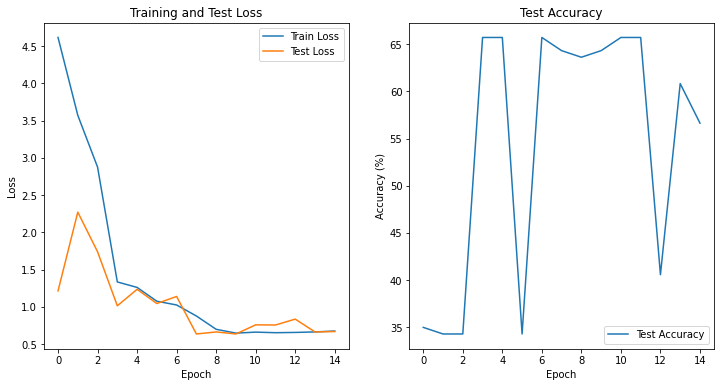

In [305]:
plt.figure(figsize=(12, 6))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [301]:
print(predicted)
print(label)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])
